In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut


In [4]:
n_clusters = 10
n_vars = 7
n_idxs = 10
results_folder = f'test4_LinReg_nc{n_clusters}_nv{n_vars}_nd{n_idxs}'
basin = 'GLB'
model_kind = 'LinReg'
n_folds = 5
start_year = 1980
end_year = 2021

# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1965-2022_2.5x2.5.csv'

# Set the paths to the files
experiment_filename = f'1965-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', f'{basin}_{n_clusters}clusters')
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
results_figure_dir = os.path.join(output_dir, 'figures')
os.makedirs(results_figure_dir, exist_ok=True)

# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)

# Load the labels files and plot the clusters for each atmospheric variable
files_labels = os.listdir(data_dir)
files_labels = [file for file in files_labels if file.startswith('label')]
files_labels.sort()

# Load the solutione file in a DataFrame
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)

# Load the file containing the best solution information 
best_solution = pd.read_csv(os.path.join(output_dir, f'best_solution_{sol_filename}'), sep=',', header=None)
best_solution = best_solution.to_numpy().flatten()

# Find solutions with best performance both for Cross-Validation and Test metric
CVbest = sol_file_df['CV'].idxmin() # metric is mean squared error
Testbest = sol_file_df['Test'].idxmin()

In [11]:
years = np.arange(start_year, end_year, 1)
filtered_target_df = target_df.loc[target_df.index.year.isin(years)]
series1 = filtered_target_df['tcg'].to_numpy()
filtered_predictors_df = predictors_df.loc[predictors_df.index.year.isin(years)]
correlations_lag0 = []
correlations_lag1 = []

for v, var in enumerate(predictors_df.columns):
    series2 = filtered_predictors_df.loc[:, var].to_numpy()
    corr0, _ = pearsonr(series1, series2)
    correlations_lag0.append(corr0)
    corr1, _ = pearsonr(series1[1:], series2[:-1])
    correlations_lag1.append(corr1)

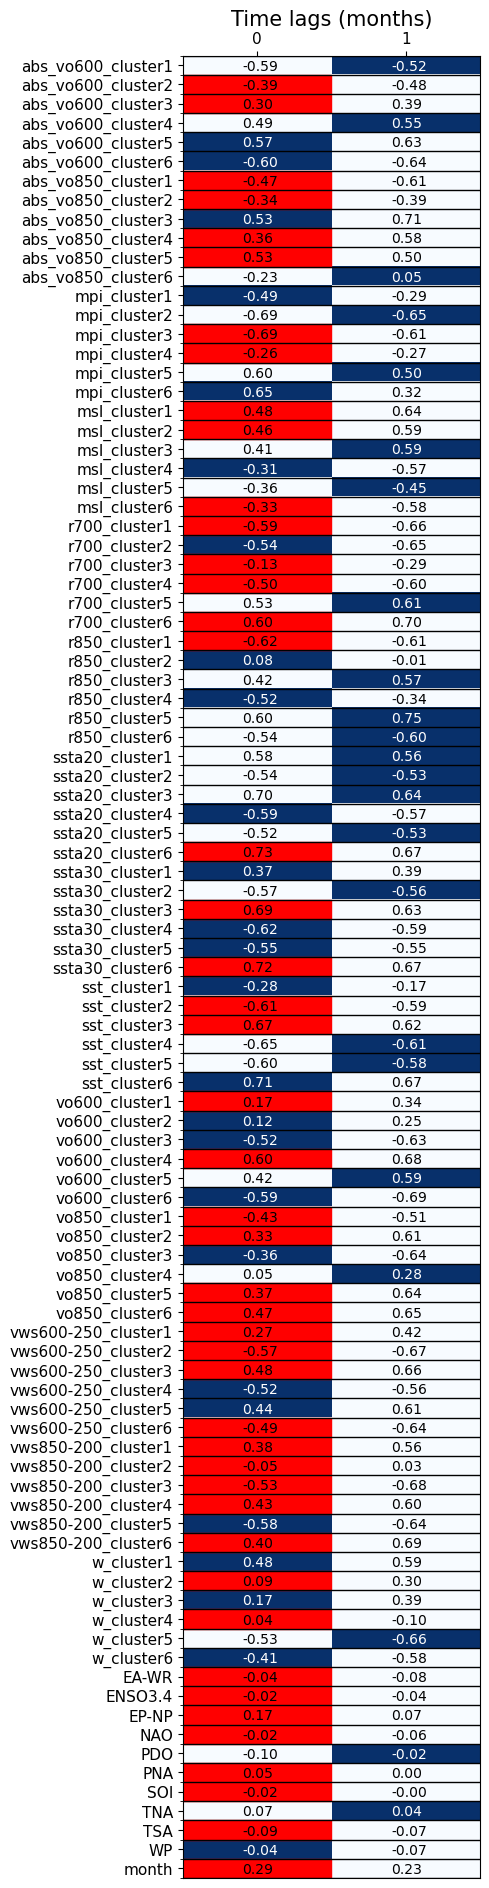

In [13]:
# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = best_solution[len(column_names):2*len(column_names)]
sequence_length = best_solution[:len(column_names)]
feat_sel = best_solution[2*len(column_names):]
n_rows = len(column_names)
n_cols = int(((sequence_length + final_sequence)*feat_sel).max())
board_best = ut.create_board(n_rows, n_cols, final_sequence, sequence_length, feat_sel)
fig_board = ut.plot_board(board_best, column_names, feat_sel, correlations_lag0, correlations_lag1, corr_report=True)

In [20]:
# Create dataset according to solution and list the labels of the selected variables
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
label_selected_vars = []
dataset_opt = target_df.copy()
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [21]:
def normalize_data(data, mins=None, maxs=None):
    """
    Normalize the data to [0, 1] and replace NaNs with -0.1.

    Inputs:
        data: numpy.ndarray
            The data to normalize
        mins: list
            The minimum values for each variable
        maxs: list
            The maximum values for each variable
    Outputs:
        normalized_data: numpy.ndarray
            The normalized data
        train_mins: list
            The minimum values for each variable
        train_maxs: list
            The maximum values for each variable
    """
    # Create a mask for NaN values
    nan_mask = np.isnan(data)
    train_mins = []
    train_maxs = []
    # Initialize an array to store the normalized data
    normalized_data = np.zeros_like(data)

    # Loop through each variable (last dimension in your data)
    for i in range(data.shape[-1]):
        # Extract the variable array
        variable_data = data[..., i]

        # Find the min and max, ignoring NaNs
        if mins == None:
            min_val = np.nanmin(variable_data)
            train_mins.append(min_val)
            max_val = np.nanmax(variable_data)
            train_maxs.append(max_val)
        else:
            min_val = mins[i]
            max_val = maxs[i]
        # Normalize the data to [0, 1], ignoring NaNs
        normalized_data[..., i] = (variable_data - min_val) / (max_val - min_val)

    # Replace NaNs with -0.1
    normalized_data[nan_mask] = -0.1

    return normalized_data, train_mins, train_maxs

In [24]:
## Train MLPregressor with the best solution found ##
# Cross-Validation for train and test years
Y_column = 'tcg' # Target variable
obs_indices = dataset_opt.index.year.isin(years)
obs_dataset = dataset_opt[obs_indices]
Y_test = obs_dataset[Y_column]
Y_pred = pd.DataFrame()

train_index = (predictors_df.index.year >= 1980) & (predictors_df.index.year <= 2013) 
test_index = (predictors_df.index.year > 2013) & (predictors_df.index.year <= 2020)

In [31]:
# Set the indices for the training and test datasets and split the dataset
train_dataset = dataset_opt[train_index]
test_dataset = dataset_opt[test_index]
X_train = train_dataset[train_dataset.columns.drop([Y_column])]
Y_train = train_dataset[Y_column]
X_test = test_dataset[test_dataset.columns.drop([Y_column])]
Y_test = test_dataset[Y_column]
X_train 

,abs_vo600_cluster1_lag1,abs_vo600_cluster4_lag1,abs_vo600_cluster5_lag0,abs_vo600_cluster6_lag0,abs_vo850_cluster3_lag0,abs_vo850_cluster6_lag1,mpi_cluster1_lag0,mpi_cluster2_lag1,mpi_cluster5_lag1,mpi_cluster6_lag0,...,vws600-250_cluster4_lag0,vws600-250_cluster5_lag0,vws850-200_cluster5_lag0,w_cluster1_lag0,w_cluster3_lag0,w_cluster5_lag1,w_cluster6_lag0,PDO_lag1,TNA_lag1,WP_lag0
1980-01-01,-0.000003,-0.000041,0.000024,0.000100,0.000060,0.000094,4.943954,9.192042,8.288747,5.939643,...,18.393382,13.356905,33.702037,-0.030569,3.937989,0.010757,2.380476,-0.42,0.26,-1.71
1980-02-01,-0.000002,-0.000044,0.000024,0.000103,0.000059,0.000099,5.428755,9.092503,7.668851,5.462938,...,18.311937,13.778032,33.084195,-0.030483,87.402821,0.020774,2.198465,-0.11,0.40,-0.50
1980-03-01,-0.000002,-0.000044,0.000026,0.000099,0.000059,0.000100,5.812414,9.028416,6.998520,4.618474,...,16.159637,16.099550,32.998877,-0.025973,61.623442,0.021495,1.803838,1.32,0.41,1.09
1980-04-01,-0.000003,-0.000042,0.000028,0.000097,0.000060,0.000100,5.982891,9.137043,6.889689,4.395997,...,15.386322,20.797909,27.810455,-0.013611,190.420341,0.013280,0.817713,1.09,0.17,0.72
1980-05-01,-0.000002,-0.000040,0.000029,0.000093,0.000061,0.000097,5.619125,9.208178,7.436566,3.612973,...,10.341561,25.278317,21.571318,-0.002923,238.506699,-0.008699,0.155564,1.49,0.56,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,-0.000004,-0.000038,0.000033,0.000086,0.000065,0.000099,4.501126,8.866220,8.971565,7.051055,...,7.016286,28.855903,12.267714,0.002634,154.920685,-0.045000,-0.133262,-1.25,0.34,-0.17
2013-09-01,-0.000005,-0.000037,0.000032,0.000087,0.000064,0.000096,4.228173,8.738653,9.230092,7.443387,...,7.620389,26.316059,11.871856,0.006130,138.588810,-0.052100,0.188803,-1.04,0.56,1.93
2013-10-01,-0.000005,-0.000037,0.000031,0.000089,0.000061,0.000094,4.192992,8.839905,9.497539,6.918707,...,7.733811,22.845340,16.625852,-0.003314,108.830881,-0.047507,0.460179,-0.48,0.61,-0.09
2013-11-01,-0.000005,-0.000038,0.000028,0.000095,0.000060,0.000094,4.191852,9.154361,9.413253,6.798943,...,12.207015,20.225450,24.899190,-0.013607,80.282170,-0.029466,1.269683,-0.87,0.66,-0.04


In [32]:
# Standardize the dataset
scaler = preprocessing.MinMaxScaler()
X_std_train = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_std_test, columns=X_test.columns, index=X_test.index)